In [46]:
import pandas as pd
from sklearn.mixture import GaussianMixture

df = pd.read_csv("dataset.csv", index_col=0)
df.rename(columns={'Real': 'Prediction', '40':'SpoofType', '41':'Illumination', '42':'Environment', '43':'Spoof'}, inplace=True)
# the prediction by silent face takes values 0-2. Gotta convert it.
df['Prediction'] = df['Prediction'].replace({0.0: 1, 1.0: 0, 2.0: 1})
df['Prediction'] = df['Prediction'].astype(int)

embeddings = pd.read_csv('dropout_embeddings.csv', index_col=0)

df = df.drop_duplicates()
common_index = df.index.intersection(embeddings.index)
df = df.loc[common_index]
embeddings = embeddings.loc[common_index]

pd.testing.assert_series_equal(df.index.to_series(), embeddings.index.to_series())


gmm = GaussianMixture(n_components=5, random_state=42)
clusters = gmm.fit_predict(embeddings)

embeddings['Spoof'] = df['Spoof']
embeddings['Cluster'] = clusters


# embeddings = pd.get_dummies(embeddings, columns=['Cluster'], dtype=int)

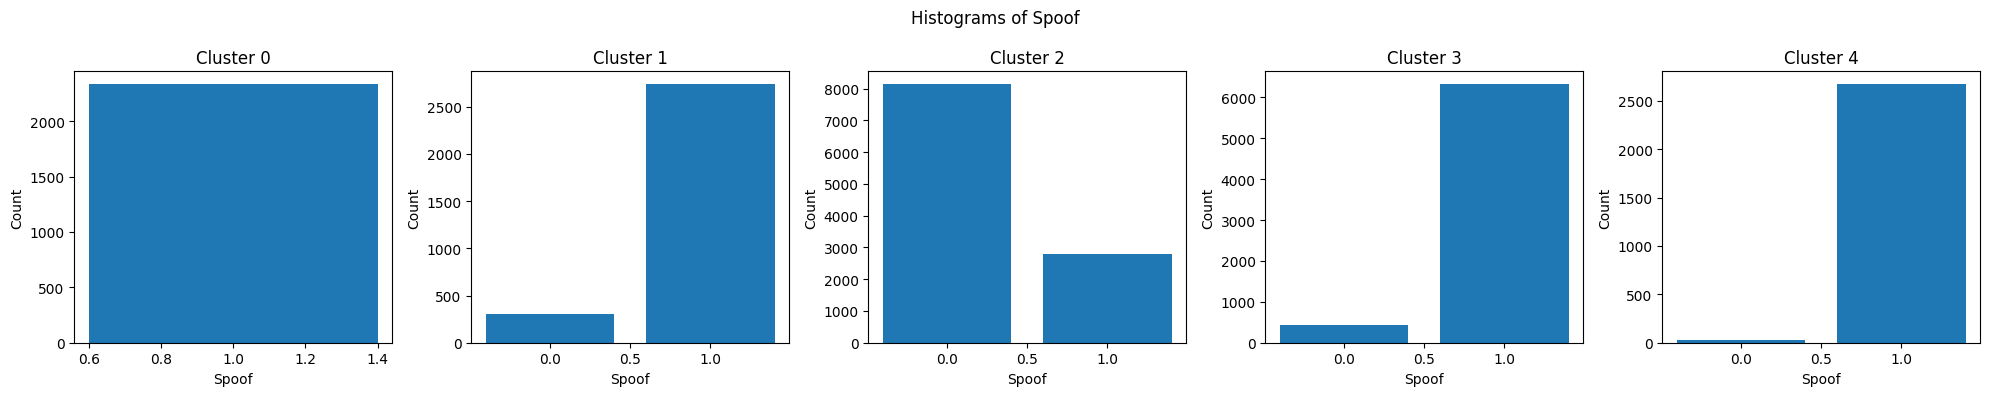

In [47]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

# Create a histogram for each cluster
for cluster_id, group in embeddings.groupby('Cluster'):
    # Count the frequency of each value of the current feature in the current cluster
    counts = group["Spoof"].value_counts()

    # Create a bar chart of the counts in the current subplot
    axs[cluster_id].bar(counts.index, counts.values)
    axs[cluster_id].set_xlabel("Spoof")
    axs[cluster_id].set_ylabel("Count")
    axs[cluster_id].set_title(f"Cluster {cluster_id}")

# Add a title to the overall plot
plt.suptitle("Histograms of Spoof")

# Adjust the layout of the subplots
plt.tight_layout()

# Display the overall plot
plt.show()

In [57]:
# hot_embeddings = pd.get_dummies(embeddings, columns=['Cluster'], dtype=int)
# hot_embeddings = hot_embeddings.reset_index(drop = True)
# hot_embeddings.head()
embeddings.head()

,1,2,3,4,5,6,7,8,9,10,...,121,122,123,124,125,126,127,128,Spoof,Cluster
Data/test/6964/spoof/494405.png,0.420929,0.391198,0.395073,-0.421826,0.368112,0.353278,0.749079,0.455125,-0.878119,-0.339846,...,-0.238815,0.688752,-0.765734,-0.755238,0.726697,-0.765685,-0.470916,0.775886,1,2
Data/test/6407/spoof/494411.png,-0.147611,0.357509,-0.029671,-0.238791,0.286075,-0.134124,0.624391,0.178886,-0.596819,-0.246836,...,-0.280803,0.680034,-0.574118,-0.704340,0.688574,-0.656510,0.135470,0.686906,1,2
Data/test/6153/spoof/494412.png,-0.105897,-0.249867,-0.077944,0.181672,-0.120957,-0.085050,0.615739,-0.094033,-0.588235,0.141131,...,0.167723,0.588970,-0.605586,-0.580930,0.522196,-0.592422,0.108543,0.643653,1,2
Data/test/6411/live/494418.png,0.441198,0.528195,0.404773,-0.509041,0.446964,0.322769,0.645940,0.537904,-0.691915,-0.460678,...,-0.460336,0.608733,-0.600595,-0.675778,0.649979,-0.616289,-0.460027,0.677907,0,2
Data/test/6336/spoof/494419.png,0.753356,0.419226,0.744619,-0.425761,0.417521,0.629097,0.054008,0.498429,-0.053692,-0.445463,...,-0.336251,0.013625,-0.103442,0.036649,0.001247,-0.089932,-0.705690,0.065030,1,0


In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


class EmbeddingsDataset(Dataset):
    def __init__(self, embeddings):
        self.embeddings = embeddings

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings.iloc[idx, :128].values, dtype=torch.float32)
        spoof = torch.tensor(self.embeddings.iloc[idx, 128], dtype=torch.long)
        cluster = torch.tensor(self.embeddings.iloc[idx, 128], dtype=torch.long)
        return embedding, spoof, cluster


class AdversarialModel(nn.Module):
    def __init__(self, num_clusters):
        super(AdversarialModel, self).__init__()
        self.step = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )

        self.anti_spoofing_head = nn.Sequential(
            nn.Linear(64, 2)
        )

        self.domain_head = nn.Sequential(
            nn.Linear(64, num_clusters)
        )

    def forward(self, x):
        x = self.step(x)
        anti_spoofing_logits = self.anti_spoofing_head(x)
        domain_logits = self.domain_head(x)
        return anti_spoofing_logits, domain_logits


In [63]:
from sklearn.model_selection import train_test_split

num_epochs = 3
learning_rate = 0.001
batch_size = 64




train_embeddings, test_embeddings = train_test_split(embeddings, test_size=0.2, random_state=42)


train_dataset = EmbeddingsDataset(train_embeddings)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = EmbeddingsDataset(test_embeddings)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AdversarialModel(2).to(device)


criterion = nn.CrossEntropyLoss()
optimizer_main = optim.Adam(model.anti_spoofing_head.parameters(), lr=learning_rate)
optimizer_domain = optim.Adam(model.domain_head.parameters(), lr=learning_rate)


target_cluster = 1
for epoch in range(num_epochs):
    for i, (embedding, spoof, cluster) in enumerate(train_loader):
        # Move the data to the device
        embedding = embedding.to(device)
        spoof = spoof.to(device)
        cluster = (cluster == target_cluster).long().to(device)

        # Step 1: Update all weights except the domain head
        optimizer_main.zero_grad()

        anti_spoofing_logits, domain_logits = model(embedding)
        loss_main = criterion(anti_spoofing_logits, spoof) - criterion(domain_logits, cluster)
        loss_main.backward()
        optimizer_main.step()

        # Step 2: Update the domain head
        optimizer_domain.zero_grad()

        _, domain_logits = model(embedding)
        loss_domain = criterion(domain_logits, cluster)
        loss_domain.backward()
        optimizer_domain.step()

        # Print progress
        if (i+1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], Loss_main: {loss_main.item()}, Loss_domain: {loss_domain.item()}")

print("Training complete.")

Epoch [1/3], Step [50/403], Loss_main: -0.008375763893127441, Loss_domain: 0.6749362945556641
Epoch [1/3], Step [100/403], Loss_main: -0.025877952575683594, Loss_domain: 0.6061168909072876
Epoch [1/3], Step [150/403], Loss_main: -0.016927242279052734, Loss_domain: 0.5669475197792053
Epoch [1/3], Step [200/403], Loss_main: -0.014607012271881104, Loss_domain: 0.5369322896003723
Epoch [1/3], Step [250/403], Loss_main: -0.006947696208953857, Loss_domain: 0.5517174601554871
Epoch [1/3], Step [300/403], Loss_main: -0.009843230247497559, Loss_domain: 0.5580552816390991
Epoch [2/3], Step [50/403], Loss_main: -0.005957901477813721, Loss_domain: 0.528634250164032
Epoch [2/3], Step [100/403], Loss_main: 0.00012022256851196289, Loss_domain: 0.5636270046234131
Epoch [2/3], Step [150/403], Loss_main: -0.004471838474273682, Loss_domain: 0.4962572753429413
Epoch [2/3], Step [200/403], Loss_main: -0.004693090915679932, Loss_domain: 0.4505188763141632
Epoch [2/3], Step [250/403], Loss_main: -0.004982054

In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Set the model to evaluation mode
model.eval()

# Define the lists to store the true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test data
for i, (embedding, spoof, cluster) in enumerate(test_loader):

    # Move the data to the device
    embedding = embedding.to(device)
    spoof = spoof.to(device)

    # Forward pass
    anti_spoofing_logits, domain_logits = model(embedding)

    # Get the predicted labels
    _, predicted = torch.max(anti_spoofing_logits, 1)

    # Append the true and predicted labels to the lists
    true_labels += spoof.tolist()
    predicted_labels += predicted.tolist()

# Calculate the evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, predicted_labels)

# Print the evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')
print(f'Roc Auc score: {roc_auc}')

Accuracy: 0.8163463405164045
Precision: 0.829214717188358
Recall: 0.90311004784689
F1 score: 0.8645863154881192
Roc Auc score: 0.7794465568509492
